In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print("Libraries loaded!")


Libraries loaded!


In [2]:
# Load predictions and true values
predictions = np.load('../results/weather_T_gemma/predictions.npy')
true_values = np.load('../results/weather_T_gemma/true_values.npy')

print(f"Predictions shape: {predictions.shape}")
print(f"True values shape: {true_values.shape}")
print(f"\nNumber of samples: {predictions.shape[0]}")
print(f"Forecast horizon: {predictions.shape[1]}")
print(f"Features: {predictions.shape[2]}")


Predictions shape: (10444, 96, 1)
True values shape: (10444, 96, 1)

Number of samples: 10444
Forecast horizon: 96
Features: 1


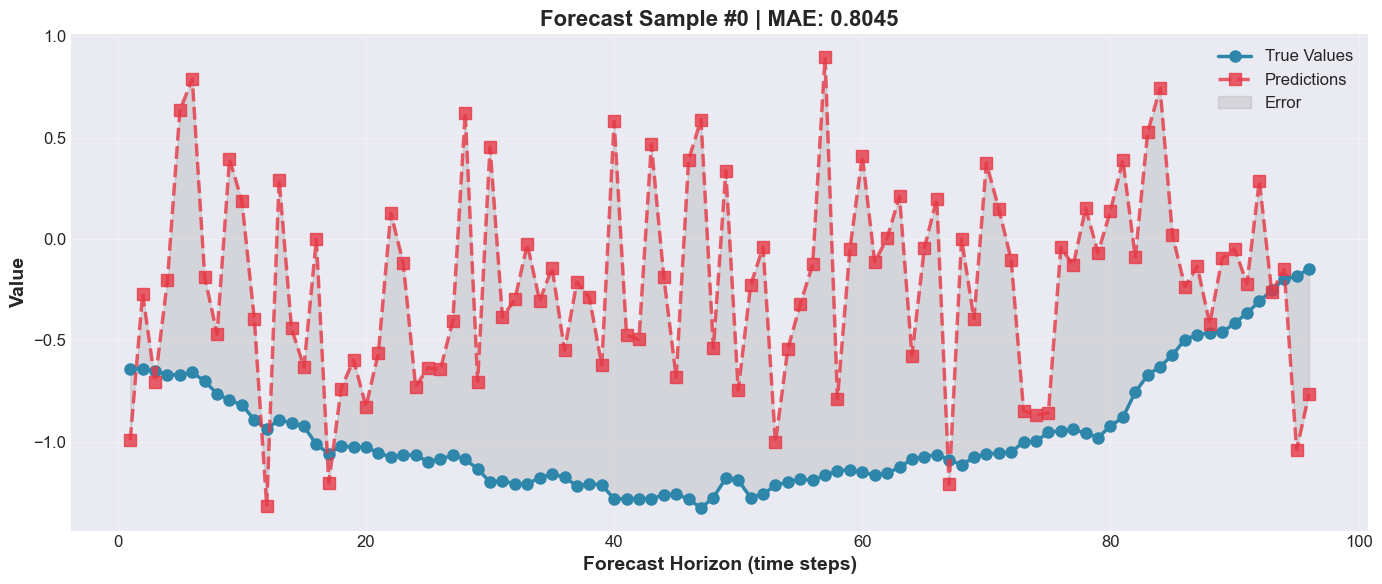

MAE for this sample: 0.8045


In [3]:
# Select a sample to visualize
sample_idx = 0
feature_idx = 0

# Extract data
pred = predictions[sample_idx, :, feature_idx]
true = true_values[sample_idx, :, feature_idx]

# Calculate MAE
mae = np.mean(np.abs(pred - true))

# Create time steps
time_steps = np.arange(1, len(true) + 1)

# Create plot
plt.figure(figsize=(14, 6))
plt.plot(time_steps, true, 'o-', label='True Values', linewidth=2.5, markersize=8, color='#2E86AB')
plt.plot(time_steps, pred, 's--', label='Predictions', linewidth=2.5, markersize=8, color='#E63946', alpha=0.8)

# Fill area between
plt.fill_between(time_steps, true, pred, alpha=0.2, color='gray', label='Error')

plt.xlabel('Forecast Horizon (time steps)', fontsize=14, fontweight='bold')
plt.ylabel('Value', fontsize=14, fontweight='bold')
plt.title(f'Forecast Sample #{sample_idx} | MAE: {mae:.4f}', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"MAE for this sample: {mae:.4f}")


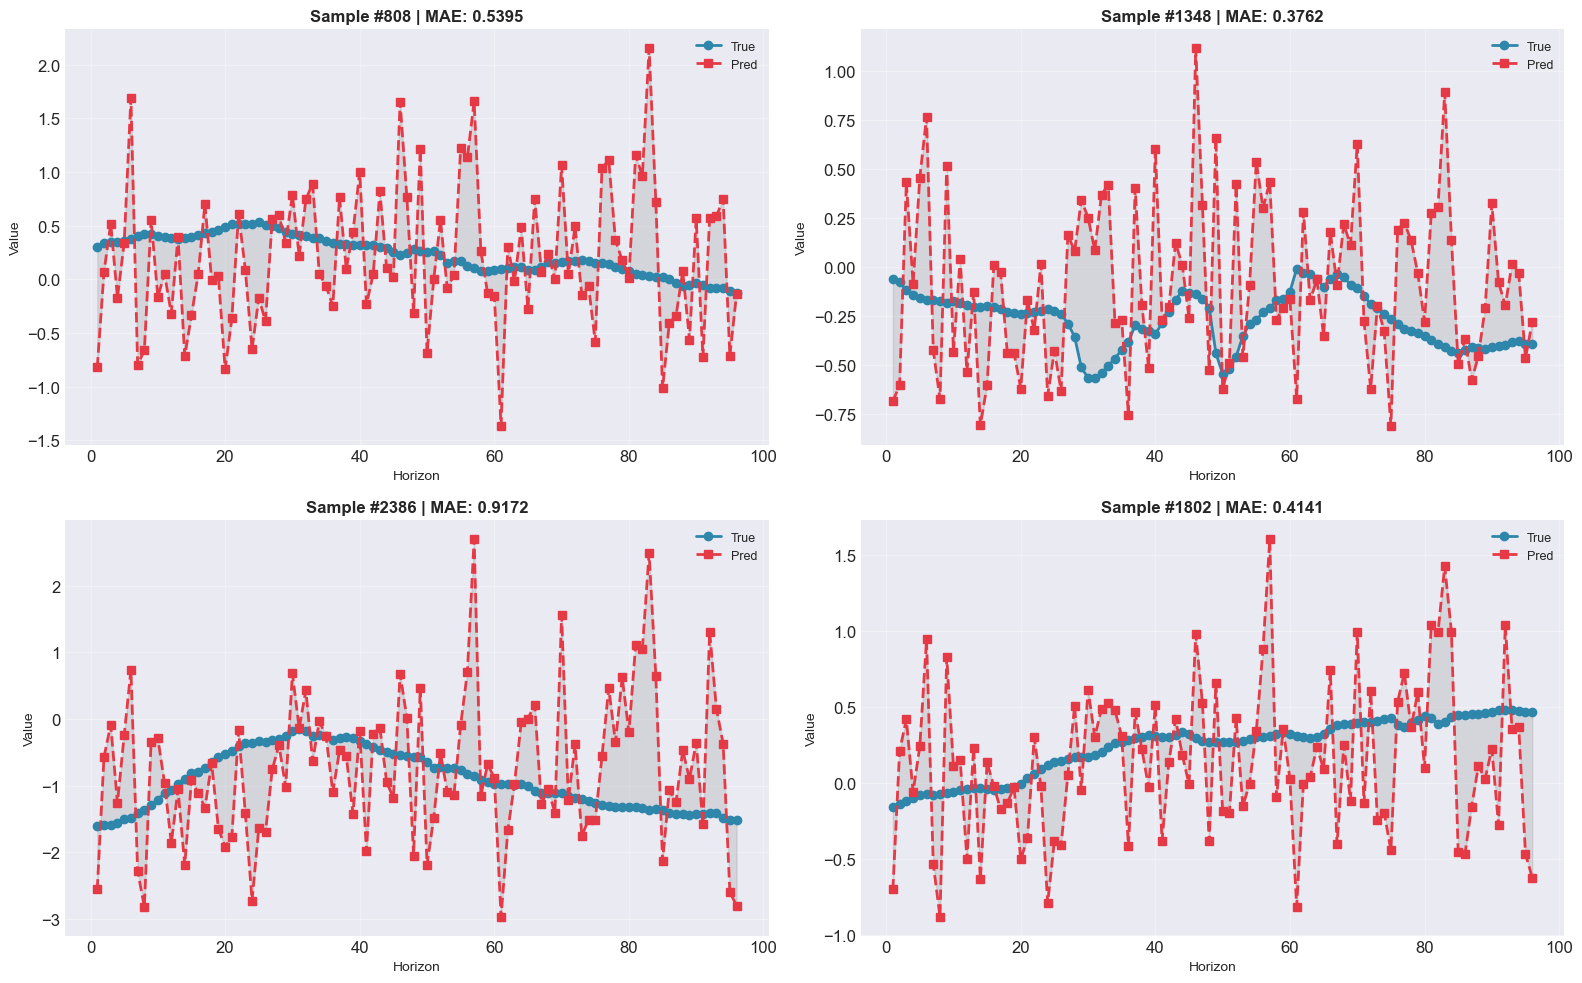

In [4]:
# Visualize multiple samples
n_samples = 4
feature_idx = 0

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Select random samples
sample_indices = np.random.choice(predictions.shape[0], n_samples, replace=False)

for i, sample_idx in enumerate(sample_indices):
    pred = predictions[sample_idx, :, feature_idx]
    true = true_values[sample_idx, :, feature_idx]
    mae = np.mean(np.abs(pred - true))
    
    time_steps = np.arange(1, len(true) + 1)
    
    axes[i].plot(time_steps, true, 'o-', label='True', linewidth=2, markersize=6, color='#2E86AB')
    axes[i].plot(time_steps, pred, 's--', label='Pred', linewidth=2, markersize=6, color='#E63946')
    axes[i].fill_between(time_steps, true, pred, alpha=0.2, color='gray')
    
    axes[i].set_title(f'Sample #{sample_idx} | MAE: {mae:.4f}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Horizon', fontsize=10)
    axes[i].set_ylabel('Value', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


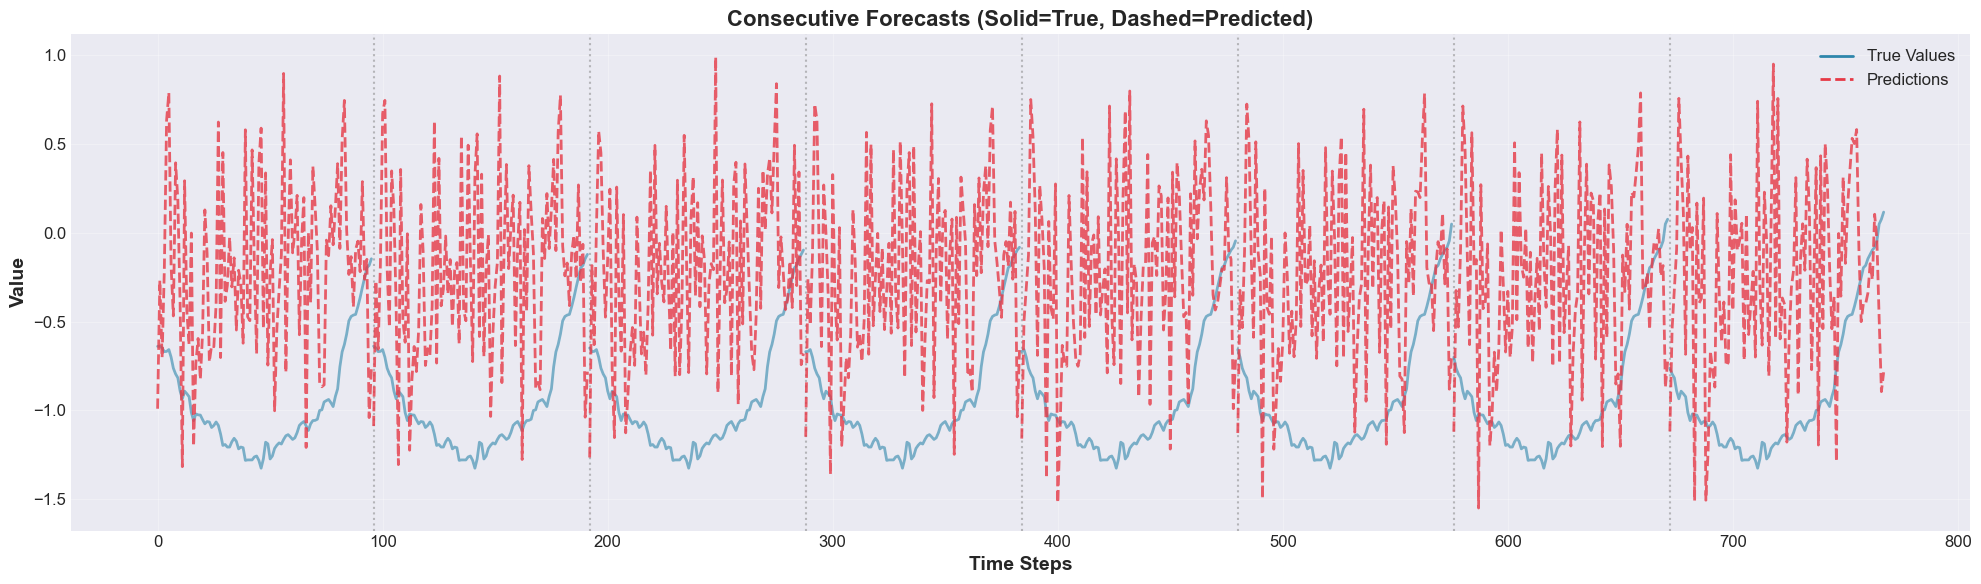

In [5]:
# Show how forecasts follow the time series
start_idx = 0
n_forecasts = 8
feature_idx = 0

plt.figure(figsize=(20, 6))

for i in range(n_forecasts):
    idx = start_idx + i
    if idx >= predictions.shape[0]:
        break
    
    pred = predictions[idx, :, feature_idx]
    true = true_values[idx, :, feature_idx]
    
    # Create offset positions
    x_offset = i * len(true)
    time_steps = np.arange(len(true)) + x_offset
    
    # Plot true values
    plt.plot(time_steps, true, '-', linewidth=2, color='#2E86AB', alpha=0.6)
    
    # Plot predictions
    plt.plot(time_steps, pred, '--', linewidth=2, color='#E63946', alpha=0.8)
    
    # Add vertical separator
    if i < n_forecasts - 1:
        plt.axvline(x=(i+1) * len(true), color='gray', linestyle=':', alpha=0.5)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#2E86AB', linewidth=2, label='True Values'),
    Line2D([0], [0], color='#E63946', linewidth=2, linestyle='--', label='Predictions')
]
plt.legend(handles=legend_elements, fontsize=12, loc='best')

plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Value', fontsize=14, fontweight='bold')
plt.title('Consecutive Forecasts (Solid=True, Dashed=Predicted)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
# Check the scale of your data
print("TRUE VALUES:")
print(f"  Min:  {true_values.min():.4f}")
print(f"  Max:  {true_values.max():.4f}")
print(f"  Mean: {true_values.mean():.4f}")
print(f"  Std:  {true_values.std():.4f}")

print("\nPREDICTIONS:")
print(f"  Min:  {predictions.min():.4f}")
print(f"  Max:  {predictions.max():.4f}")
print(f"  Mean: {predictions.mean():.4f}")
print(f"  Std:  {predictions.std():.4f}")

print("\n" + "="*50)
if true_values.mean() < 1.0 and true_values.mean() > -1.0:
    print("⚠️  Data appears to be NORMALIZED (scaled)")
    print("    Need to inverse transform to get original values!")
else:
    print("✅  Data appears to be in ORIGINAL scale")


TRUE VALUES:
  Min:  -1.9484
  Max:  1.1234
  Mean: -0.7859
  Std:  0.6482

PREDICTIONS:
  Min:  -4.7432
  Max:  4.8646
  Mean: -0.6113
  Std:  0.8414

⚠️  Data appears to be NORMALIZED (scaled)
    Need to inverse transform to get original values!


In [7]:
# Load the original weather dataset to get the scaler
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load raw data
df_raw = pd.read_csv('../dataset/weather/weather.csv')
print(f"Original data shape: {df_raw.shape}")
print(f"Columns: {df_raw.columns.tolist()}")


Original data shape: (52696, 22)
Columns: ['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)', 'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT']


In [8]:
# Check what the target variable looks like in original scale
target = 'T (degC)'  # Your target column
print(f"\nOriginal '{target}' statistics:")
print(f"  Min:  {df_raw[target].min():.2f}")
print(f"  Max:  {df_raw[target].max():.2f}")
print(f"  Mean: {df_raw[target].mean():.2f}")
print(f"  Std:  {df_raw[target].std():.2f}")

# Show first few values
print(f"\nFirst 10 values: {df_raw[target].head(10).values}")



Original 'T (degC)' statistics:
  Min:  -6.44
  Max:  34.80
  Mean: 10.82
  Std:  7.47

First 10 values: [0.71 0.75 0.73 0.37 0.33 0.34 0.19 0.03 0.11 0.22]


In [9]:
df_raw.head()


,date,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2


In [11]:
# Recreate the scaler used during training
# This follows the same logic as in Dataset_Custom.__read_data__()

cols = list(df_raw.columns)
cols.remove(target)
cols.remove('date')
df_raw_reordered = df_raw[['date'] + cols + [target]]

# Get training data (70% for training)
num_train = int(len(df_raw) * 0.7)
if 'S' in 'S':  # Univariate - single target
    df_data = df_raw_reordered[[target]]
else:  # Multivariate
    df_data = df_raw_reordered[df_raw_reordered.columns[1:]]

# Fit scaler on training data
train_data = df_data[0:num_train]
scaler = StandardScaler()
scaler.fit(train_data.values)

print("Scaler statistics:")
print(f"  Mean: {scaler.mean_}")
print(f"  Scale (std): {scaler.scale_}")


Scaler statistics:
  Mean: [11.97874319]
  Scale (std): [7.71842219]


In [12]:
# Inverse transform predictions and true values
predictions_original = scaler.inverse_transform(
    predictions.reshape(-1, predictions.shape[-1])
).reshape(predictions.shape)

true_values_original = scaler.inverse_transform(
    true_values.reshape(-1, true_values.shape[-1])
).reshape(true_values.shape)

print("AFTER INVERSE TRANSFORM:")
print("\nTrue values (original scale):")
print(f"  Min:  {true_values_original.min():.2f}")
print(f"  Max:  {true_values_original.max():.2f}")
print(f"  Mean: {true_values_original.mean():.2f}")

print("\nPredictions (original scale):")
print(f"  Min:  {predictions_original.min():.2f}")
print(f"  Max:  {predictions_original.max():.2f}")
print(f"  Mean: {predictions_original.mean():.2f}")

print("\n✅ Data is now in ORIGINAL scale (e.g., actual temperature, humidity, etc.)")


AFTER INVERSE TRANSFORM:

True values (original scale):
  Min:  -3.06
  Max:  20.65
  Mean: 5.91

Predictions (original scale):
  Min:  -24.63
  Max:  49.53
  Mean: 7.26

✅ Data is now in ORIGINAL scale (e.g., actual temperature, humidity, etc.)


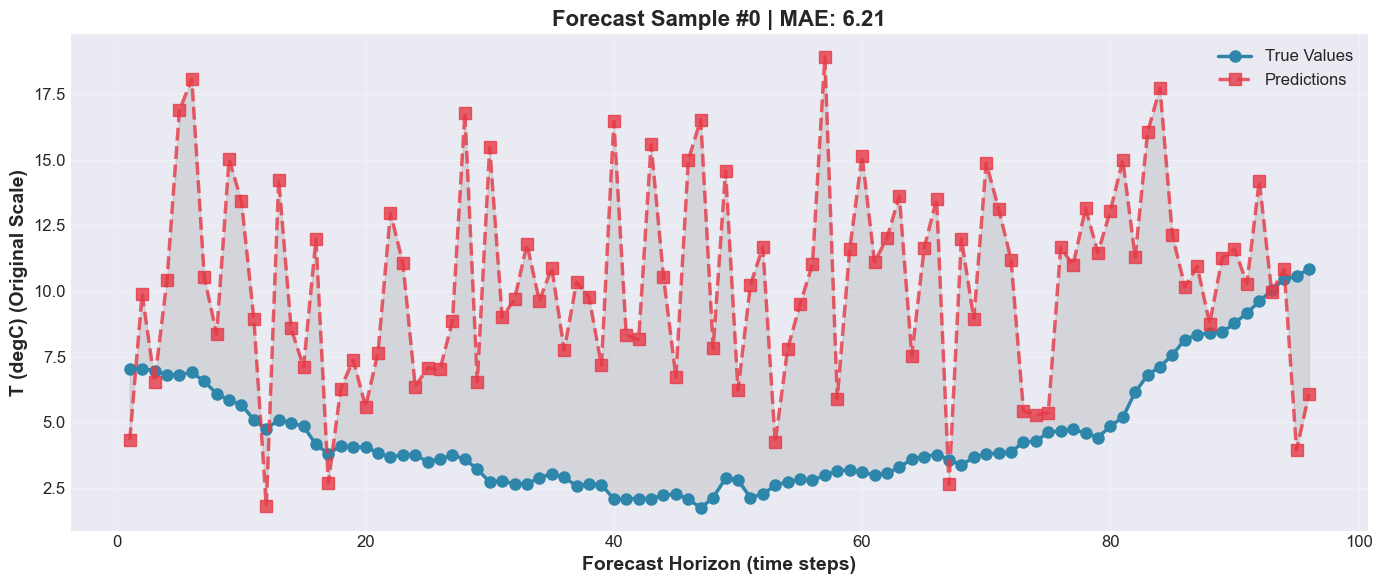

MAE in original scale: 6.21
True values range: [1.74, 10.85]
Predictions range: [1.81, 18.91]


In [13]:
# Visualize with REAL values
sample_idx = 0
feature_idx = 0

pred = predictions_original[sample_idx, :, feature_idx]
true = true_values_original[sample_idx, :, feature_idx]

mae = np.mean(np.abs(pred - true))

time_steps = np.arange(1, len(true) + 1)

plt.figure(figsize=(14, 6))
plt.plot(time_steps, true, 'o-', label='True Values', linewidth=2.5, markersize=8, color='#2E86AB')
plt.plot(time_steps, pred, 's--', label='Predictions', linewidth=2.5, markersize=8, color='#E63946', alpha=0.8)
plt.fill_between(time_steps, true, pred, alpha=0.2, color='gray')

plt.xlabel('Forecast Horizon (time steps)', fontsize=14, fontweight='bold')
plt.ylabel(f'{target} (Original Scale)', fontsize=14, fontweight='bold')
plt.title(f'Forecast Sample #{sample_idx} | MAE: {mae:.2f}', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"MAE in original scale: {mae:.2f}")
print(f"True values range: [{true.min():.2f}, {true.max():.2f}]")
print(f"Predictions range: [{pred.min():.2f}, {pred.max():.2f}]")


In [14]:
# Calculate MAE and MAPE on original scale
def calculate_metrics_original(preds, trues):
    preds_flat = preds.reshape(-1)
    trues_flat = trues.reshape(-1)
    
    mae = np.mean(np.abs(preds_flat - trues_flat))
    mse = np.mean((preds_flat - trues_flat) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((trues_flat - preds_flat) / (np.abs(trues_flat) + 1e-8))) * 100
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

metrics_original = calculate_metrics_original(predictions_original, true_values_original)

print("="*60)
print("METRICS ON ORIGINAL SCALE")
print("="*60)
print(f"MAE:   {metrics_original['MAE']:.4f}")
print(f"RMSE:  {metrics_original['RMSE']:.4f}")
print(f"MAPE:  {metrics_original['MAPE']:.2f}%")
print("="*60)


METRICS ON ORIGINAL SCALE
MAE:   3.9993
RMSE:  5.5738
MAPE:  268676.62%


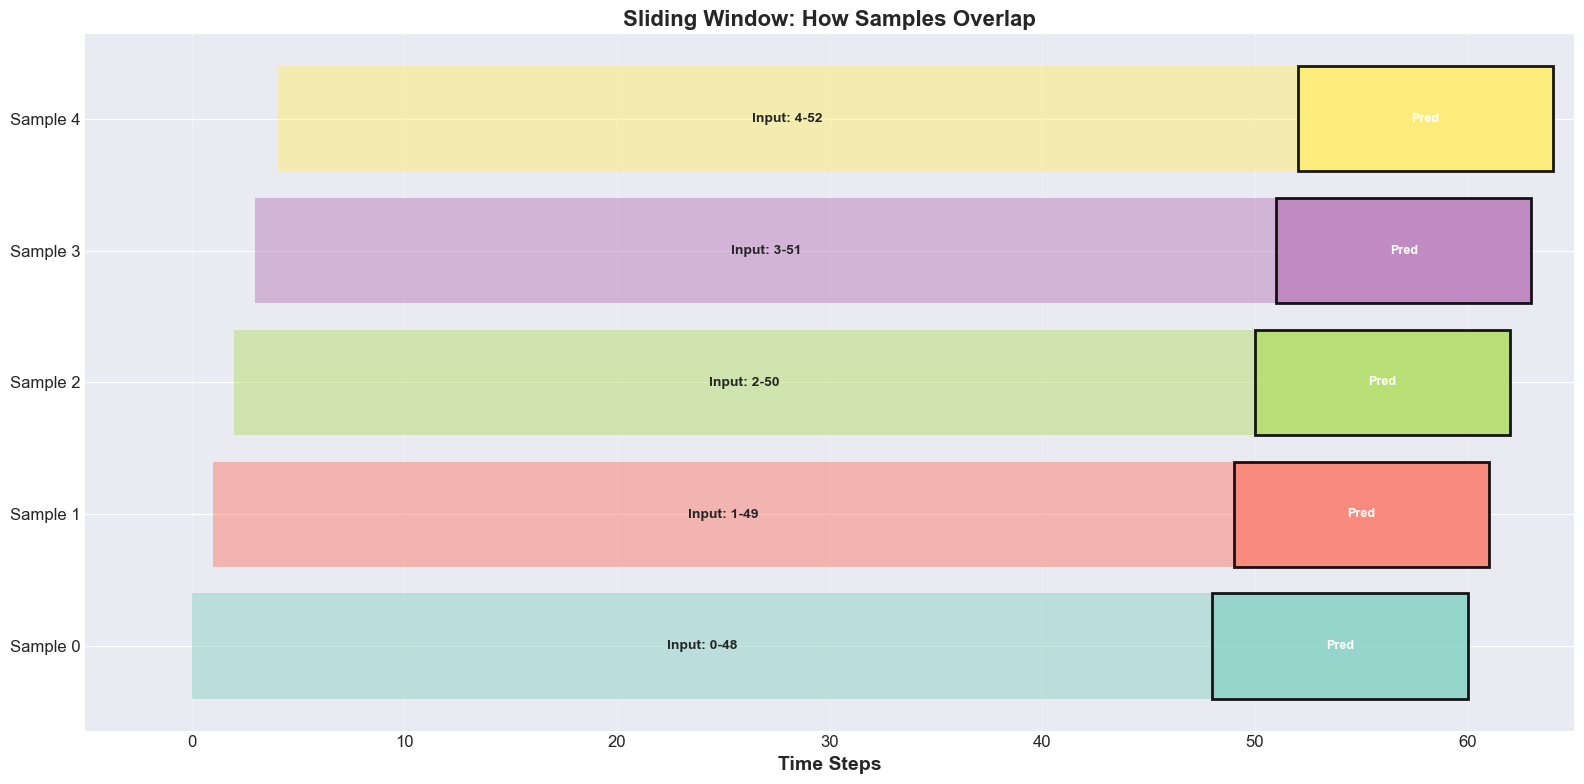


Notice how each sample slides forward by 1 time step!
Input windows (light colored) show the 48 historical steps
Prediction windows (dark colored) show the 12 forecast steps


In [15]:
# Visualize how samples overlap
fig, ax = plt.subplots(figsize=(16, 8))

# Show first 5 samples and how they overlap
n_show = 5
colors = plt.cm.Set3(np.linspace(0, 1, n_show))

for i in range(n_show):
    # Input window
    input_start = i
    input_end = i + 48
    ax.barh(i, 48, left=input_start, height=0.8, color=colors[i], alpha=0.5, label=f'Sample {i} Input')
    
    # Prediction window
    pred_start = input_end
    pred_end = pred_start + 12
    ax.barh(i, 12, left=pred_start, height=0.8, color=colors[i], alpha=0.9, edgecolor='black', linewidth=2)
    
    # Add text
    ax.text(input_start + 24, i, f'Input: {input_start}-{input_end}', 
            ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(pred_start + 6, i, f'Pred', 
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')

ax.set_yticks(range(n_show))
ax.set_yticklabels([f'Sample {i}' for i in range(n_show)])
ax.set_xlabel('Time Steps', fontsize=14, fontweight='bold')
ax.set_title('Sliding Window: How Samples Overlap', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(-5, 65)

plt.tight_layout()
plt.show()

print("\nNotice how each sample slides forward by 1 time step!")
print("Input windows (light colored) show the 48 historical steps")
print("Prediction windows (dark colored) show the 12 forecast steps")


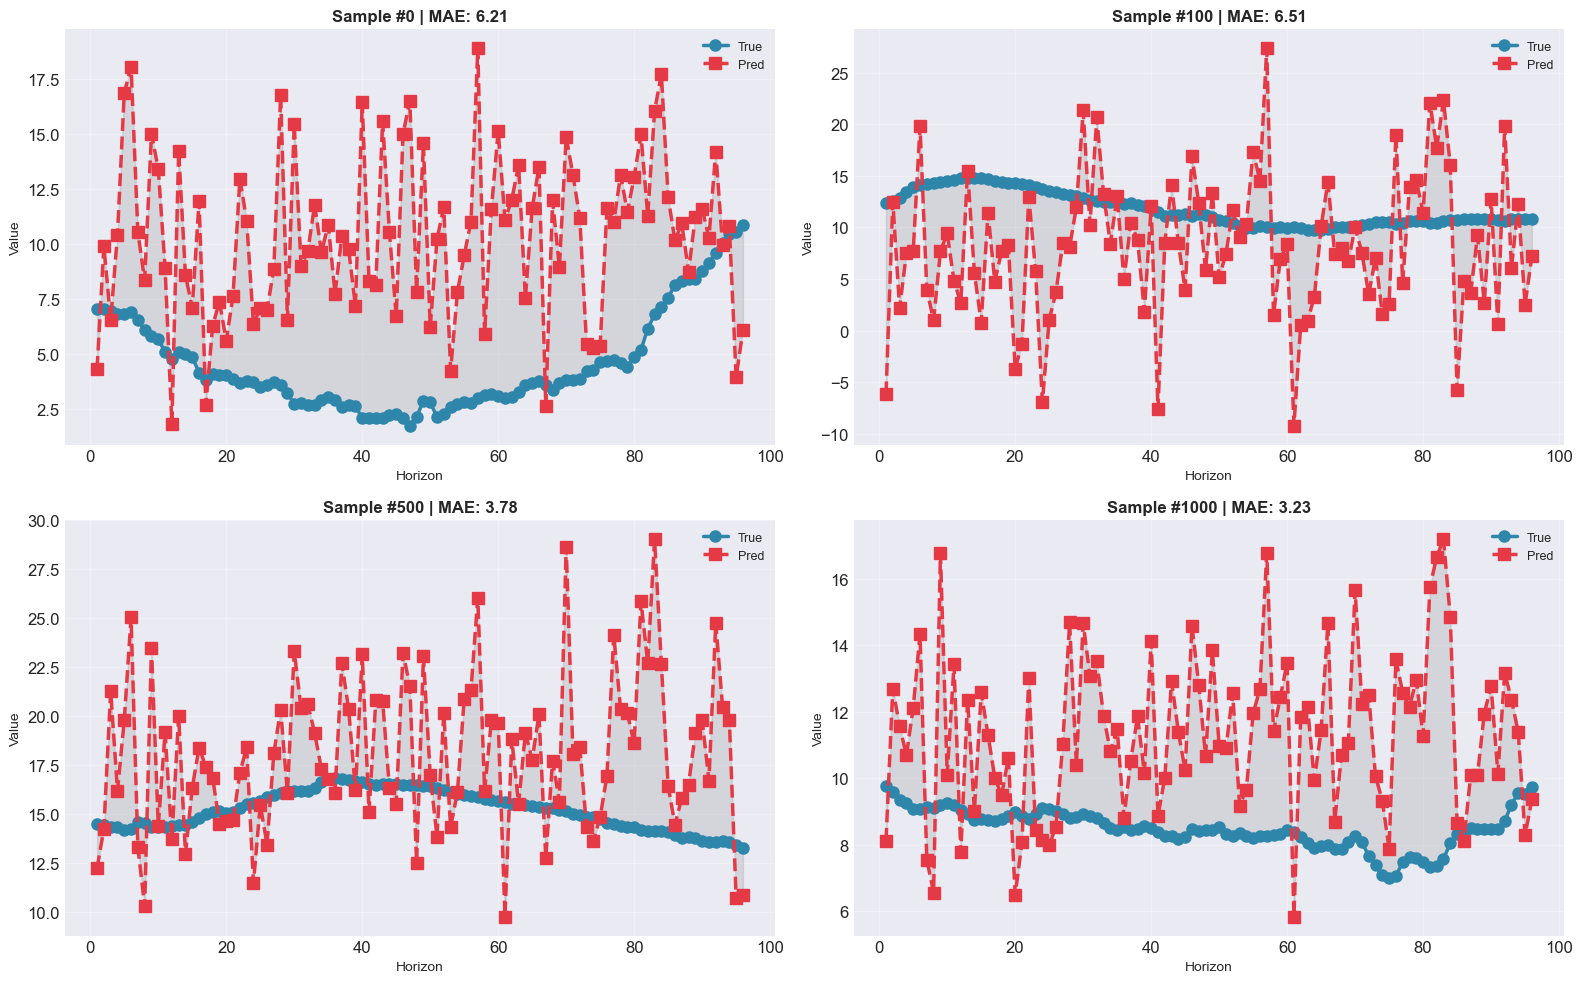

In [16]:
# Check multiple samples to see if this is consistent
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

sample_indices = [0, 100, 500, 1000]

for i, sample_idx in enumerate(sample_indices):
    pred = predictions_original[sample_idx, :, 0]
    true = true_values_original[sample_idx, :, 0]
    mae = np.mean(np.abs(pred - true))
    
    time_steps = np.arange(1, len(true) + 1)
    
    axes[i].plot(time_steps, true, 'o-', label='True', linewidth=2.5, markersize=8, color='#2E86AB')
    axes[i].plot(time_steps, pred, 's--', label='Pred', linewidth=2.5, markersize=8, color='#E63946')
    axes[i].fill_between(time_steps, true, pred, alpha=0.2, color='gray')
    
    axes[i].set_title(f'Sample #{sample_idx} | MAE: {mae:.2f}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Horizon', fontsize=10)
    axes[i].set_ylabel('Value', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [17]:
# Overall prediction quality
mae_all = np.mean(np.abs(predictions_original - true_values_original))
print(f"Overall MAE: {mae_all:.2f}")

# Check if predictions have reasonable variance
print(f"\nTrue values std: {true_values_original.std():.2f}")
print(f"Predictions std: {predictions_original.std():.2f}")

# Are predictions just random?
correlation = np.corrcoef(
    predictions_original.flatten(), 
    true_values_original.flatten()
)[0, 1]
print(f"\nCorrelation between predictions and true: {correlation:.4f}")
print(f"  (1.0 = perfect, 0.0 = random, -1.0 = opposite)")


Overall MAE: 4.00

True values std: 5.00
Predictions std: 6.49

Correlation between predictions and true: 0.5840
  (1.0 = perfect, 0.0 = random, -1.0 = opposite)


In [18]:
# Visualize: Input Time Series → Forecast
# Need to load the actual input data (not just predictions)

import sys
sys.path.append('..')
from data_provider.data_factory import data_provider

# Recreate args to load test data with ALL required attributes
class Args:
    def __init__(self):
        # Data config
        self.data = 'Weather'
        self.root_path = '../dataset/weather/'
        self.data_path = 'weather.csv'
        self.features = 'S'
        self.target = 'T (degC)'
        self.seq_len = 48
        self.label_len = 24
        self.pred_len = 12
        self.freq = 'h'
        self.embed = 'timeF'
        self.percent = 100
        self.num_workers = 0
        self.loader = 'modal'
        self.seasonal_patterns = 'Monthly'
        
        # Model config (needed by data loader)
        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        
        # Training config
        self.batch_size = 4
        self.eval_batch_size = 4
        
        # Other
        self.task_name = 'long_term_forecast'
        self.scale = True
        self.timeenc = 0

args = Args()
test_data, test_loader = data_provider(args, 'test')

print(f"Test dataset loaded: {len(test_data)} samples")
print(f"Batch size: {args.batch_size}")


Test dataset loaded: 10528 samples
Batch size: 4


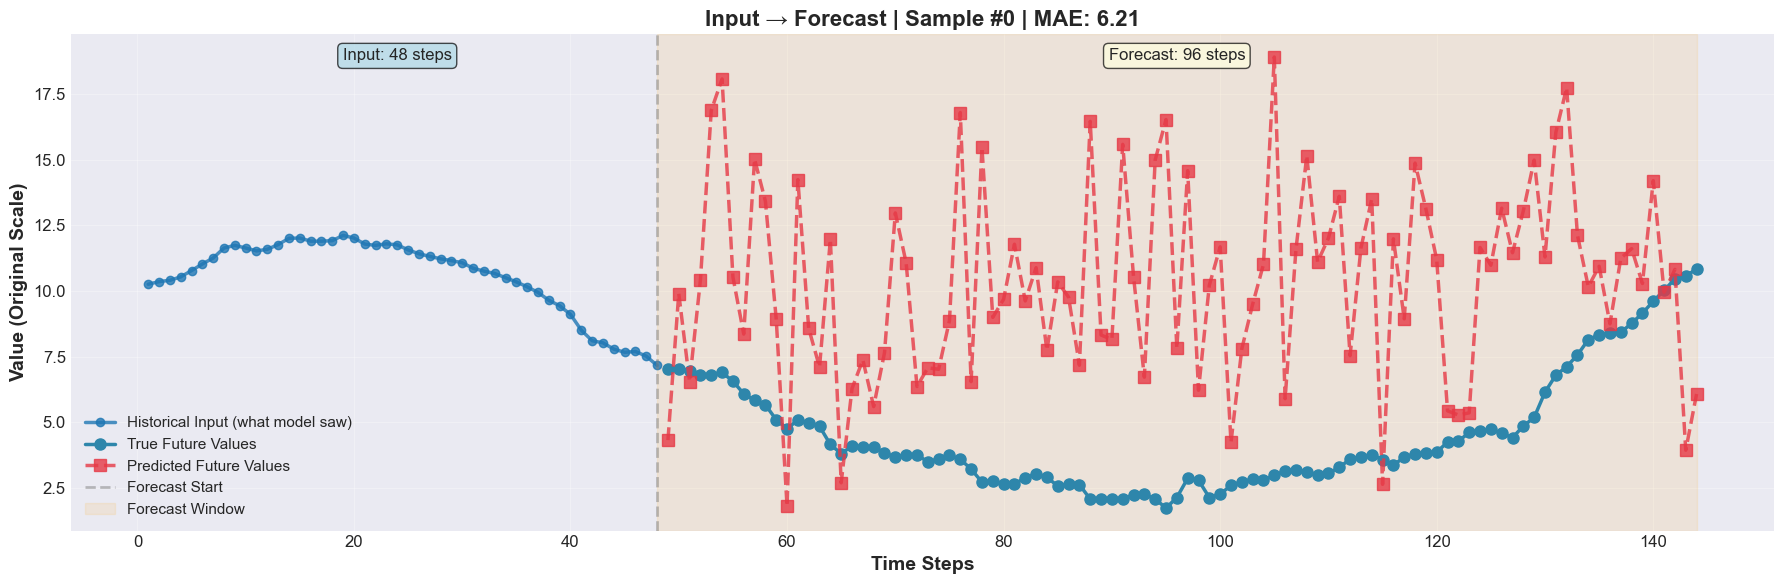

In [19]:
def plot_input_and_forecast(sample_idx, feature_idx=0):
    """
    Plot input sequence + forecast in one continuous chart
    """
    # Get the sample from test dataset
    batch_x, batch_y, batch_x_mark, batch_y_mark = test_data[sample_idx]
    
    # Input sequence (what model saw)
    input_seq = batch_x[:, feature_idx]  # Shape: (seq_len,)
    
    # True future values
    true_future = batch_y[-args.pred_len:, feature_idx]  # Shape: (pred_len,)
    
    # Model predictions (already loaded)
    pred_future = predictions[sample_idx, :, feature_idx]  # Shape: (pred_len,)
    
    # Inverse transform to original scale
    # For input
    input_seq_original = scaler.inverse_transform(
        input_seq.reshape(-1, 1)
    ).flatten()
    
    # For true future (already done above, use true_values_original)
    true_future_original = true_values_original[sample_idx, :, feature_idx]
    
    # For predictions (already done above, use predictions_original)
    pred_future_original = predictions_original[sample_idx, :, feature_idx]
    
    # Calculate MAE
    mae = np.mean(np.abs(pred_future_original - true_future_original))
    
    # Create time axis
    input_time = np.arange(1, len(input_seq_original) + 1)
    forecast_time = np.arange(len(input_seq_original) + 1, 
                              len(input_seq_original) + len(true_future_original) + 1)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 6))
    
    # Plot input sequence (historical data)
    ax.plot(input_time, input_seq_original, 'o-', 
            label='Historical Input (what model saw)', 
            linewidth=2.5, markersize=6, color='#1f77b4', alpha=0.8)
    
    # Plot true future values
    ax.plot(forecast_time, true_future_original, 'o-', 
            label='True Future Values', 
            linewidth=2.5, markersize=8, color='#2E86AB')
    
    # Plot predictions
    ax.plot(forecast_time, pred_future_original, 's--', 
            label='Predicted Future Values', 
            linewidth=2.5, markersize=8, color='#E63946', alpha=0.8)
    
    # Add vertical line to separate input from forecast
    ax.axvline(x=len(input_seq_original), color='gray', 
               linestyle='--', linewidth=2, alpha=0.5, 
               label='Forecast Start')
    
    # Shade forecast region
    ax.axvspan(len(input_seq_original), 
               len(input_seq_original) + len(true_future_original), 
               alpha=0.1, color='orange', label='Forecast Window')
    
    # Styling
    ax.set_xlabel('Time Steps', fontsize=14, fontweight='bold')
    ax.set_ylabel('Value (Original Scale)', fontsize=14, fontweight='bold')
    ax.set_title(f'Input → Forecast | Sample #{sample_idx} | MAE: {mae:.2f}', 
                 fontsize=16, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add annotations
    ax.text(len(input_seq_original)//2, ax.get_ylim()[1]*0.95, 
            f'Input: {len(input_seq_original)} steps', 
            ha='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    ax.text(len(input_seq_original) + len(true_future_original)//2, ax.get_ylim()[1]*0.95, 
            f'Forecast: {len(true_future_original)} steps', 
            ha='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    
    plt.tight_layout()
    return fig

# Plot sample 0
plot_input_and_forecast(0)
plt.show()


In [21]:
# Check what OT is
df_raw = pd.read_csv('../dataset/weather/weather.csv')
print("Weather dataset columns:")
print(df_raw.columns.tolist())
print("\nOT statistics:")
print(df_raw['T (degC)'].describe())


Weather dataset columns:
['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)', 'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT']

OT statistics:
count    52696.000000
mean        10.818241
std          7.468671
min         -6.440000
25%          4.590000
50%         10.230000
75%         16.180000
max         34.800000
Name: T (degC), dtype: float64
